## E-14 OCR

In [ ]:
import easyocr
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
IMAGE_PATH = 'test.png'

In [ ]:
image = cv2.imread(IMAGE_PATH)

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 15)
edged = cv2.Canny(blur, 10, 500)
plt.imshow(edged)

In [ ]:
reader = easyocr.Reader(['es'], gpu=False)
result = reader.readtext(edged, allowlist ='0123456789')
result

In [ ]:
img = cv2.imread(IMAGE_PATH)
for detection in result:
    top_left = tuple([int(val) for val in detection[0][0]])
    bottom_right = tuple([int(val) for val in detection[0][2]])
    text = detection[1]
    font = cv2.FONT_HERSHEY_SIMPLEX
    img = cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 1)
    img = cv2.putText(img, text, top_left, font, 0.35, (0, 100, 0), 1, cv2.LINE_AA)
    
_ = plt.figure(figsize=(20, 15))
_ = plt.imshow(img)

## Convolutional Neural Network - Waste Management

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
import math
from sklearn.model_selection import train_test_split

In [9]:
DIR = 'data'
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))

classes = train_dataset.class_names
num_classes = len(classes)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 2390 files belonging to 5 classes.
Using 2151 files for training.
Found 2390 files belonging to 5 classes.
Using 239 files for validation.
['cardboard', 'glass', 'metal', 'paper', 'plastic']


In [ ]:
baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=num_classes)
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 50
lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[])

1/1 [==============================] - 9s 9s/step
[ 6.430872 24.49062  41.990467 11.634332 15.453701] 
 ['cardboard', 'glass', 'metal', 'paper', 'plastic']
Prediction:  metal 41.99046790599823%


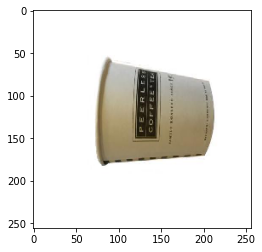

In [14]:
model = tf.keras.models.load_model('model.h5')

path = 'prueba.jpg'

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")